In [158]:
# import packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold

import altair.vegalite.v3 as alt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#alt.data_transformers.enable('json')
#alt.renderers.enable('notebook')

In [159]:
# load csv
df = pd.read_csv('../data/raw.csv')

In [160]:
# drop unecessary index column
df = df.drop(df.columns[0], 1)

# Add column names
new_col_names = ['Sex',
                 'Age',
                 'Debt',
                 'Married',
                 'BankCustomer',
                 'EducationLevel',
                 'Ethnicity',
                 'YearsEmployed',
                 'PriorDefault',
                 'Employed',
                 'CreditScore',
                 'DriversLicense',
                 'Citizen',
                 'ZipCode',
                 'Income',
                 'Approved'
                ]

df.columns = new_col_names

In [161]:
# split test and train data
X = df.drop(['Approved'], 1)
y = df[['Approved']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [5]:
# create pandas profiling report
train_df = X_train.join(y_train)
profile = ProfileReport(df, title='Pandas Profiling Report')

In [6]:
profile.to_file(output_file="../doc/report.html")

**Link to pandas profiling report:** [link](https://htmlpreview.github.io/?https://github.com/UBC-MDS/DSCI_522_Group_412/blob/master/doc/report.html)

In [70]:
X_train.describe(include = "all")

,Sex,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income
count,552,552,552.000000,552,552,552,552,552.000000,552,552,552.000000,552,552,552,552.000000
unique,3,311,NaN,4,4,15,10,NaN,2,2,NaN,2,3,143,NaN
top,b,?,NaN,u,g,c,v,NaN,t,f,NaN,f,g,00000,NaN
freq,377,9,NaN,409,409,109,321,NaN,283,315,NaN,302,503,106,NaN
mean,NaN,NaN,4.604520,NaN,NaN,NaN,NaN,2.048134,NaN,NaN,2.400362,NaN,NaN,NaN,920.070652
std,NaN,NaN,4.807331,NaN,NaN,NaN,NaN,2.923399,NaN,NaN,4.853296,NaN,NaN,NaN,4787.304994
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
25%,NaN,NaN,1.030000,NaN,NaN,NaN,NaN,0.165000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
50%,NaN,NaN,2.750000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.000000,NaN,NaN,NaN,5.000000
75%,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,2.551250,NaN,NaN,3.000000,NaN,NaN,NaN,400.000000


### Initial observations
- There are no missing values, but there are many features with zeroes. We should inspect these to ensure they are not errors.
- `Age` is currently a categorical feature, but should be numeric.
- `Married` is highly correlated with `BankCustomer`. We may need to remove one of these features (or combine them) to avoid issues of multicollinearity in our models.
- There are categorical features (e.g. `Citizen` and `BankCustomer`) that will need to be transformed through OHE or another method.
- The numeric features have different scales and will need to be standardized or normalized to work with some of the models we are considering.
- The dataset is well balanced, with `Approved` having 55.5% of data in one class and 45.5% in the other class
- For the variable 'Sex', since the documentation does not map the labels a/b to male/female, we'll leave the variable as is
- Several columns indicate the character "?" as value(s). We can interpret them as missing values and transform accordingly

## Data Wrangling

In [162]:
# Dealing with missing data identified as "?"
X_train = X_train.replace('?', np.nan)
X_test = X_test.replace('?', np.nan)

> Under the time constraint we will substitute the missing values for the numerical variables with the median value and for the categorical variables, with the most common occurring category value ie. mode

In [163]:
# Change age from string to float
X_train.Age = X_train.Age.astype(float)
X_test.Age = X_test.Age.astype(float)

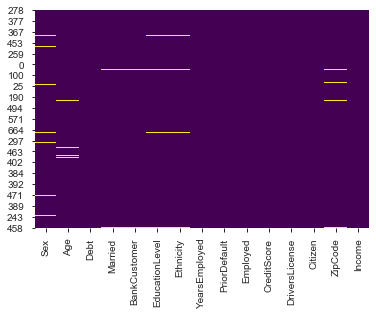

In [164]:
sns.heatmap(X_train.isnull(), cmap='viridis', cbar=False);
#sns.heatmap(X_test.isnull(), cmap='viridis', cbar=False);

- From the heatmap we observe some missing values (now = Nan) in 7 out of the 15 columns

In [165]:
# Dealing with missing data

# Numerical Variable Age - Substituting with median values
X_train.fillna(X_train.median(), inplace=True)
X_test.fillna(X_test.median(), inplace=True)

#For Categorical features - replace missing values with the most common occuring category value
X_train = X_train.apply(lambda x: x.fillna(x.value_counts().index[0]))
X_test = X_test.apply(lambda x: x.fillna(x.value_counts().index[0]))

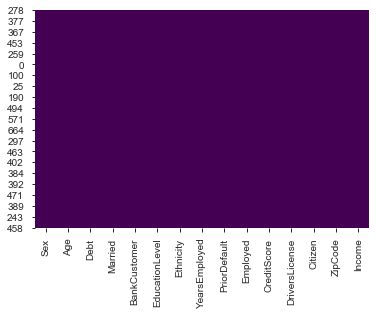

In [77]:
sns.heatmap(X_train.isnull(), cmap ='viridis', cbar = False);

- No more missing values

In [166]:
# Change PriorDefault to False and True
X_train['PriorDefault'] = X_train['PriorDefault'].replace({'f': 'False', 't': 'True'})
X_test['PriorDefault'] = X_test['PriorDefault'].replace({'f': 'False', 't': 'True'})

# Change Employed to False and True
X_train['Employed'] = X_train['Employed'].replace({'f': 'False', 't': 'True'})
X_test['Employed'] = X_test['Employed'].replace({'f': 'False', 't': 'True'})

# Change target to 0 and 1
y_train['Approved'] = y_train['Approved'].replace({'-': 0, '+': 1})
y_test['Approved'] = y_test['Approved'].replace({'-': 0, '+': 1})

### Data Visualization: Numerical variables with target variable

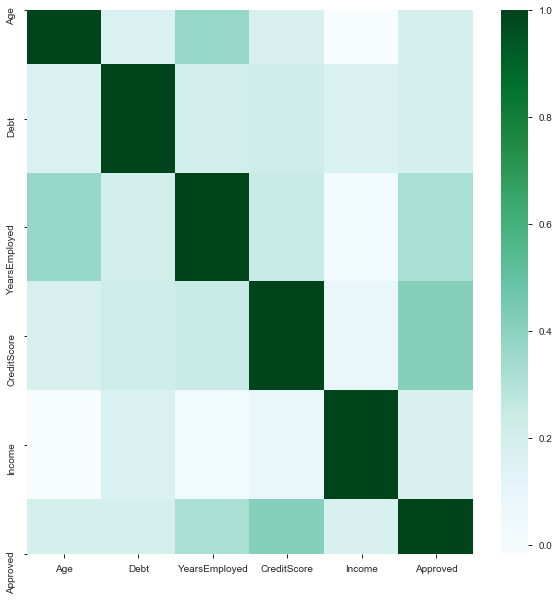

In [80]:
# plot correlation matrix for numeric variables against target
train_df = X_train.join(y_train)
plt.figure(figsize=(10,10)) 
sns.heatmap(train_df.corr(), cmap='BuGn')

- From the matrix we observe that variable `CreditScore` may have a strong correlation with the target variable `Approved`
- Similarly, `YearsEmployed` may have significant correlation with `Approved`
- Remaining variables do not exhibit significant correlation with`Approved`
- Variables `Age` and `YearsEmployed` have a significant correlation with each other
- But these correlations need to be re-assessed after the analysis of skewness in the continuous variables

### Data Visualization: Categorical variables

In [16]:
def make_plot(feature):
    """
    Plots the bar plot of the feature variable against the target variable

    Parameters
    ----------
    feature: list of strings
             categorical feature name(s) in the dataset 

    Returns
    -------
    plot: altair.vegalite.v3.api.Chart
          A bar plot of the feature variable against the target variable

    Examples
    --------
    >>> make_plot("Sex")
    """
    
    plot = alt.Chart(train_df).mark_bar().encode(
        alt.X(feature, type = "nominal"),
        alt.Y("count()", title = "Frequency",axis=alt.Axis(grid=False)),
        alt.Column("Approved")
        ).properties(width=200, height=400).configure_header(title=None
        ).configure_axis(titleFontSize=18, titleFontWeight = 400, labelFontWeight = 400, labelFontSize = 16
        ).configure_mark(color='teal', opacity=0.5)
    return plot

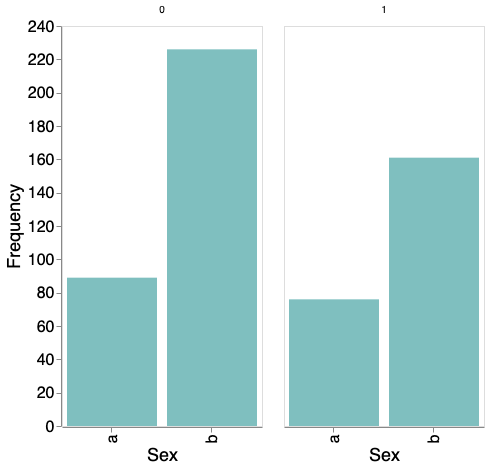

In [117]:
plot_2 = make_plot("Sex")
plot_2

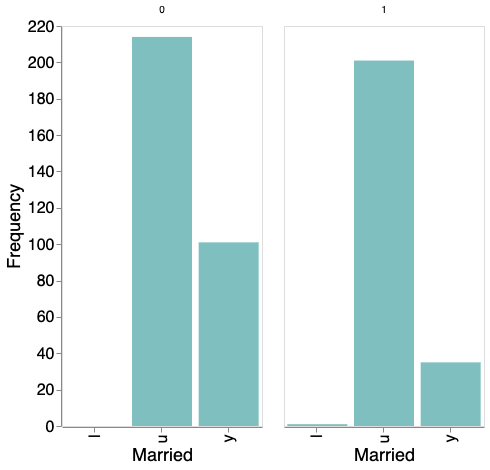

In [118]:
plot_3 = make_plot("Married")
plot_3

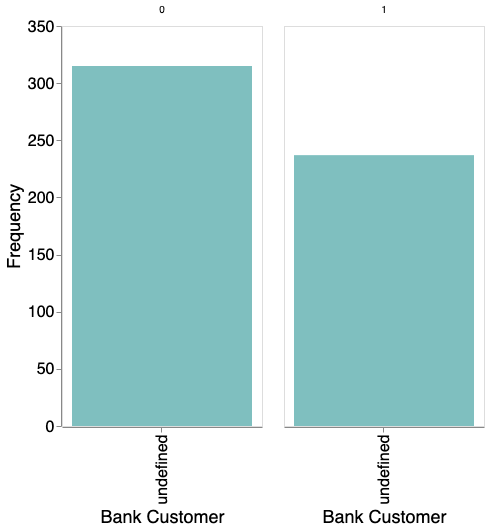

In [119]:
plot_4 = make_plot("Bank Customer")
plot_4

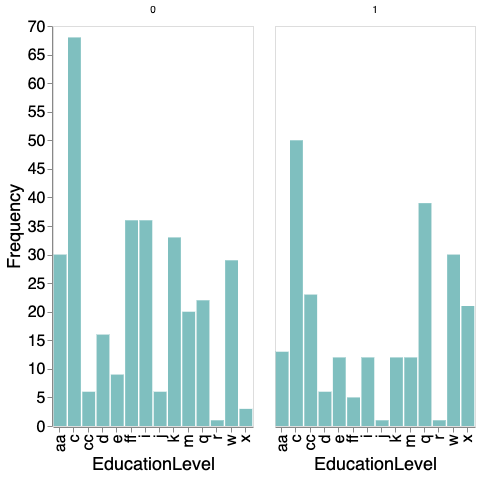

In [120]:
plot_5 = make_plot("EducationLevel")
plot_5

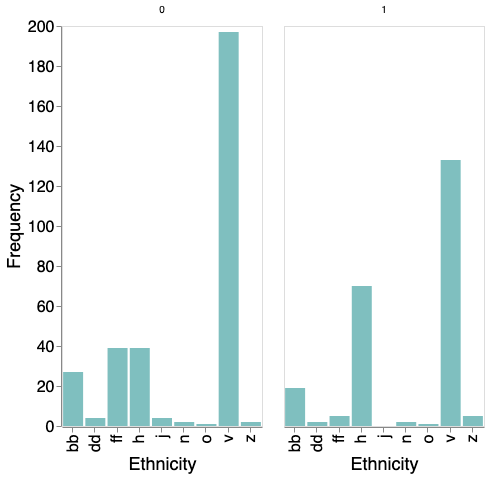

In [121]:
plot_6 = make_plot("Ethnicity")
plot_6

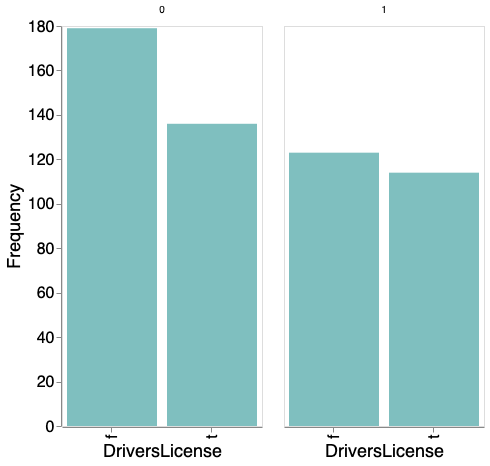

In [122]:
plot_7 = make_plot("DriversLicense")
plot_7

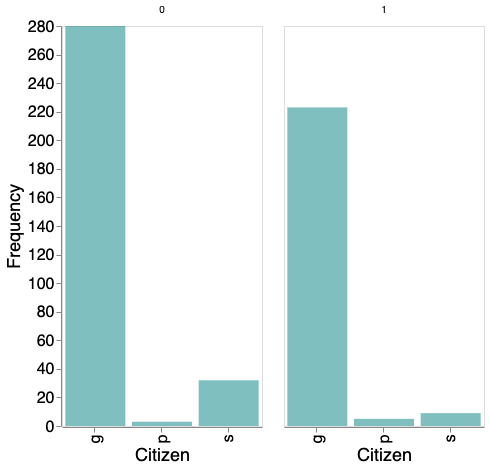

In [123]:
plot_8 = make_plot("Citizen")
plot_8

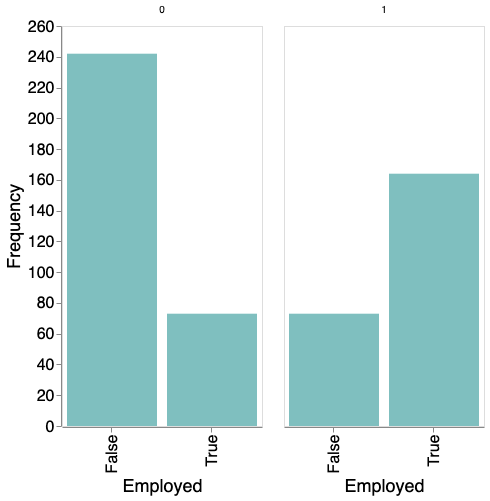

In [124]:
plot_9 = make_plot("Employed")
plot_9

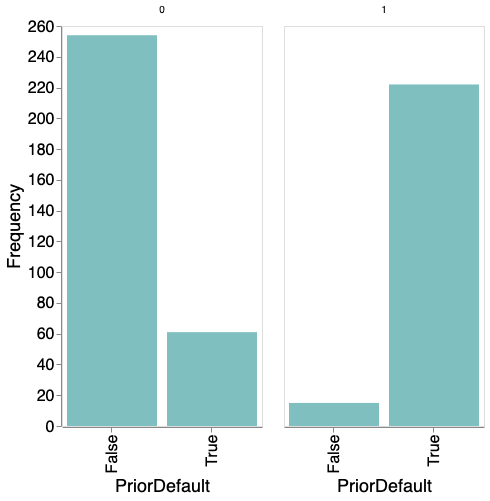

In [125]:
plot10 = make_plot("PriorDefault")
plot10

### Observations
* Only two of the categorical features namely `Employed` (indicating employment status) and `PriorDefault` (indicating previous credit default history) show significant correlation with the target response `Approved`

## Preprocessing

In [171]:
#X_train.head()
# All numeric features - X_train.select_dtypes(include = np.number)
numeric_features = ['Age','Debt','YearsEmployed','CreditScore','Income']
#categorical features - X_train.select_dtypes(exclude = np.number)
categorical_features = ['Sex','Ethnicity', 'Married','BankCustomer','EducationLevel','PriorDefault','Employed','DriversLicense','Citizen','ZipCode']

In [172]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), numeric_features),
        ('ohe', OneHotEncoder(drop='first',sparse=False), categorical_features)])

X_train_processed = preprocessor.fit_transform(X_train)
#X_test_processed = preprocessor.transform(X_test)

In [ ]:
X_test_processed = preprocessor.tranform(X_test)

## Feature Selection

In [173]:
## Get names of the features whose correlation > threshold = 0.8

correlated_features = set()
correlation_matrix =X_train.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
correlated_features
# Nofeatures with collinarity > 0.8
# so can use all features for rfecv

set()

In [179]:
rfc = RandomForestClassifier(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_processed, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=101,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [184]:
# Drope features of low importance
X_train_processed = pd.DataFrame(X_train_processed)
X_train_processed.drop(X_train_processed.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

In [192]:
# Dataframe with important features
processed_feature_dataset = pd.DataFrame()

processed_feature_dataset['attribute'] = pd.DataFrame(X_train_processed).columns
processed_feature_dataset['importance'] = rfecv.estimator_.feature_importances_

# Sorting in descending order
processed_feature_dataset = processed_feature_dataset.sort_values(by='importance', ascending=False)
processed_feature_dataset.describe()

,attribute,importance
count,169.000000,1.690000e+02
mean,86.928994,5.917160e-03
std,51.331158,2.405206e-02
min,0.000000,5.951346e-08
25%,42.000000,1.339533e-04
50%,87.000000,6.202760e-04
75%,130.000000,2.947791e-03
max,176.000000,2.644683e-01


In [200]:
# importance threshold >= 0.01
final_features = processed_feature_dataset.loc[(processed_feature_dataset['importance'] >= 0.01)]
final_features

,attribute,importance
31,31,0.264468
2,2,0.089454
3,3,0.072816
4,4,0.072287
1,1,0.069399
0,0,0.067853
32,32,0.056588
33,33,0.012899
8,8,0.012233
30,30,0.012029
